In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%pylab inline
import scipy
from scipy.stats import poisson
from hmmlearn.utils import normalize
sys.path.append('../')
from rl.mmpp import MMPP

Populating the interactive namespace from numpy and matplotlib


# Helper functions

In [55]:
# load indexed log
def load_dataframes(prefix, n_run, n=None):
    if n is None:
        n = n_run
    files = [prefix + "_{}.log".format(i) for i in range(n)]
    file_list = ['./log/index/'+ prefix +'_x{}/'.format(n_run) +'index_'+file+'.csv' for file in files]
    df_list = [None]*n
    for i in range(n):
        t = time.time()
        df = pd.read_csv(file_list[i], delimiter=';', index_col=0)
        df.loc[:, 'start_ts'] = df['start_ts'].apply(lambda x: pd.to_datetime(x))
        df.set_index('start_ts', inplace=True)
        df['total_reward'] = df['tr_reward'] + df['op_cost']
        df_list[i] = df
        print df.shape,
        print files[i],
        print "{:.2f} sec".format(time.time()-t)
    return df_list    

In [56]:
# get per-step reward from loaded DataFrame
def get_step_reward(file_prefix, num_total, num_load):
    df_list = load_dataframes(file_prefix, num_total, num_load)
    df_list = filter(lambda x: x.shape[0]==302400, df_list)
    start = pd.to_datetime("2014-10-16 9:30:00")
    end = pd.to_datetime("2014-10-21 9:30:00")
    delta = pd.Timedelta('2 seconds')

    step_reward = np.zeros(len(df_list))
    for i, df in enumerate(df_list):
        df = df.loc[start:end]
        print (i, df.shape[0])
        step = (df.index-df.index[0])/delta+1
        ts = df['total_reward'].cumsum()/step
        step_reward[i] = ts.iloc[-1]
    return step_reward

In [57]:
# Get baseline per-step_reward from loaded DataFrame
def get_baseline(file_prefix, num_total, num_load):
    df_list = load_dataframes(file_prefix, num_total, num_load)
    df_list = filter(lambda x: x.shape[0]==302400, df_list)
    start = pd.to_datetime("2014-10-16 9:30:00")
    end = pd.to_datetime("2014-10-21 9:30:00")
    delta = pd.Timedelta('2 seconds')

    baselines = np.zeros(len(df_list))
    for i, df in enumerate(df_list):
        df = df.loc[start:end]
        print (i, df.shape[0])
        step = (df.index-df.index[0])/delta+1
        ts = df['req_generated'].cumsum()/step
        baselines[i] = ts.iloc[-1] - 5.0
    return baselines

In [34]:
# Load per-step rewards from .reward file and calculate statistics
def get_stats(f, n, baseline=0.0):
    with open('./log/index/{f}_x{n}/{f}.reward'.format(f=f, n=n), 'r') as f_reward:
        line = f_reward.readlines()[0]
        step_reward = np.array(map(float, line[1:-2].split(',')))
        step_reward -= baseline
        print "mean {:.3f}, std {:.3f},".format(step_reward.mean(), step_reward.std()),
        print "10% {:.3f}, 50% {:.3f}, 90% {:.3f},".format(*np.percentile(step_reward, [10, 50, 90])),
        print "{} sims".format(len(step_reward))
    return step_reward, step_reward.mean(), step_reward.std(), np.percentile(step_reward, 10), np.percentile(step_reward, 50), np.percentile(step_reward, 90)

---

# Table 3

In [7]:
baseline_dh3 = -3.9641868942
baseline_dsy = 2.49294833512
baseline_mechcenter = -4.28022864092
baseline_dormW = -4.71388095425
baseline_mediaB = -2.91390934919
baseline_newgym = -4.4175304744
##################################################################
# # Uncomment below to calculate baseline from indexed log files
##################################################################
# baselines = get_baseline("msg_QNN_Jan31_1154", 10, 3); baseline_dh3 = np.mean(baselines)
# baselines = get_baseline("msg_QNN_Feb1_1740", 14, 3); baseline_dsy = np.mean(baselines)
# baselines = get_baseline("msg_QNN_Feb2_0930", 14, 3); baseline_mechcenter = np.mean(baselines)
# baselines = get_baseline("msg_QNN_Feb2_0944", 14, 3); baseline_dormW = np.mean(baselines)
# baselines = get_baseline("msg_QNN_Feb2_0953", 14, 3); baseline_mediaB = np.mean(baselines)
# baselines = get_baseline("msg_QNN_Feb2_1004", 14, 3); baseline_newgym = np.mean(baselines)

In [35]:
print " "*25+"dh3"
print "{:20s}".format('Baseline'),
print "     {:.2f}".format(baseline_dh3)
exps = [
    ('QL-d', "msg_DynaQtable_130_Feb12_2217", 14),
    ('DQN-m', "msg_DynaQNN_130_Feb15_2000", 14),
    ('DQN-d', "msg_DynaQNN_130_Feb12_2215", 14),
    ('DQN', "msg_QNN_Jan31_1154", 10),
]
step_rewards, params, means, stds, p10s, p50s, p90s = [], [], [], [], [], [], []
for p, f, n in exps:
    print "{:20s}".format(p),
    step_reward, mean, std, p10, p50, p90 = get_stats(f, n, baseline_dh3)
    step_rewards.append(step_reward.tolist()), params.append(p), means.append(mean); stds.append(std); p10s.append(p10); p50s.append(p50); p90s.append(p90)

print " "*25+"dsy"
print "{:20s}".format('Baseline'),
print "     {:.2f}".format(baseline_dsy)
exps = [
    ('QL-d', "msg_DynaQtable_Feb12_2232", 14),
    ('DQN-m', "msg_DynaQNN_Feb15_2050", 14),
    ('DQN-d', "msg_DynaQNN_Feb12_2226", 14),
    ('DQN', "msg_QNN_Feb1_1740", 14), 
]
step_rewards, params, means, stds, p10s, p50s, p90s = [], [], [], [], [], [], []
for p, f, n in exps:
    print "{:20s}".format(p),
    step_reward, mean, std, p10, p50, p90 = get_stats(f, n, baseline_dsy)
    step_rewards.append(step_reward.tolist()), params.append(p), means.append(mean); stds.append(std); p10s.append(p10); p50s.append(p50); p90s.append(p90)

print " "*25+"dmW"
print "{:20s}".format('Baseline'),
print "     {:.2f}".format(baseline_dormW)
exps = [
    ('QL-d', "msg_DynaQtable_Feb7_1052", 14),
    ('DQN-m', "msg_DynaQNN_130_Feb10_2316", 14),
    ('DQN-d', "msg_DynaQNN_Feb5_1007", 14),
    ('DQN', "msg_QNN_Feb2_0944", 14),
]
step_rewards, params, means, stds, p10s, p50s, p90s = [], [], [], [], [], [], []
for p, f, n in exps:
    print "{:20s}".format(p),
    step_reward, mean, std, p10, p50, p90 = get_stats(f, n, baseline_dormW)
    step_rewards.append(step_reward.tolist()), params.append(p), means.append(mean); stds.append(std); p10s.append(p10); p50s.append(p50); p90s.append(p90)    
    
print " "*25+"mhC"
print "{:20s}".format('Baseline'),
print "     {:.2f}".format(baseline_mechcenter)
exps = [
    ('QL-d', "msg_DynaQtable_130_Feb14_0027", 14),
    ('DQN-m', "msg_DynaQNN_130_Feb15_2001", 14),
    ('DQN-d', "msg_DynaQNN_130_Feb14_0026", 14),
    ('DQN', "msg_QNN_Feb2_0930", 14),
]
step_rewards, params, means, stds, p10s, p50s, p90s = [], [], [], [], [], [], []
for p, f, n in exps:
    print "{:20s}".format(p),
    step_reward, mean, std, p10, p50, p90 = get_stats(f, n, baseline_mechcenter)
    step_rewards.append(step_reward.tolist()), params.append(p), means.append(mean); stds.append(std); p10s.append(p10); p50s.append(p50); p90s.append(p90)
    
print " "*25+"mdB"
print "{:20s}".format('Baseline'),
print "     {:.2f}".format(baseline_mediaB)
exps = [
    ('QL-d', "msg_DynaQtable_Feb13_2359", 14),
    ('DQN-m', "msg_DynaQNN_Feb15_2051", 14),
    ('DQN-d', "msg_DynaQNN_Feb13_2358", 14),
    ('DQN', "msg_QNN_Feb2_0953", 14),
]
step_rewards, params, means, stds, p10s, p50s, p90s = [], [], [], [], [], [], []
for p, f, n in exps:
    print "{:20s}".format(p),
    step_reward, mean, std, p10, p50, p90 = get_stats(f, n, baseline_mediaB)
    step_rewards.append(step_reward.tolist()), params.append(p), means.append(mean); stds.append(std); p10s.append(p10); p50s.append(p50); p90s.append(p90)

print " "*25+"gym"
print "{:20s}".format('Baseline'),
print "     {:.2f}".format(baseline_newgym)
exps = [
    ('QL-d', "msg_DynaQtable_130_Feb14_0029", 14),
    ('DQN-m', "msg_DynaQNN_130_Feb15_2002", 14),
    ('DQN-d', "msg_DynaQNN_130_Feb14_0028", 14),
    ('DQN', "msg_QNN_Feb2_1004", 14),
]
step_rewards, params, means, stds, p10s, p50s, p90s = [], [], [], [], [], [], []
for p, f, n in exps:
    print "{:20s}".format(p),
    step_reward, mean, std, p10, p50, p90 = get_stats(f, n, baseline_newgym)
    step_rewards.append(step_reward.tolist()), params.append(p), means.append(mean); stds.append(std); p10s.append(p10); p50s.append(p50); p90s.append(p90)

                         dh3
Baseline                  -3.96
QL-d                 mean 3.280, std 0.009, 10% 3.267, 50% 3.281, 90% 3.287, 14 sims
DQN-m                mean 3.443, std 0.008, 10% 3.434, 50% 3.443, 90% 3.454, 11 sims
DQN-d                mean 3.490, std 0.004, 10% 3.485, 50% 3.489, 90% 3.495, 12 sims
DQN                  mean 3.481, std 0.004, 10% 3.477, 50% 3.480, 90% 3.485, 10 sims
                         dsy
Baseline                  2.49
QL-d                 mean 1.384, std 0.042, 10% 1.323, 50% 1.398, 90% 1.425, 14 sims
DQN-m                mean 1.616, std 0.091, 10% 1.473, 50% 1.632, 90% 1.700, 14 sims
DQN-d                mean 1.879, std 0.007, 10% 1.871, 50% 1.879, 90% 1.887, 14 sims
DQN                  mean 1.903, std 0.008, 10% 1.893, 50% 1.903, 90% 1.913, 14 sims
                         dmW
Baseline                  -4.71
QL-d                 mean 3.678, std 0.007, 10% 3.670, 50% 3.678, 90% 3.687, 14 sims
DQN-m                mean 3.898, std 0.006, 10% 3.889

# Figure 2

In [24]:
f = './log/index_message_2016-6-8_XXX.log.csv'

df = pd.read_csv(f, delimiter=';', index_col=0)
df.loc[:, 'start_ts'] = df['start_ts'].apply(lambda x: pd.to_datetime(x))
df.set_index('start_ts', inplace=True)
df['total_reward'] = df['tr_reward'] - df['op_cost']
delta = pd.Timedelta('2 seconds')

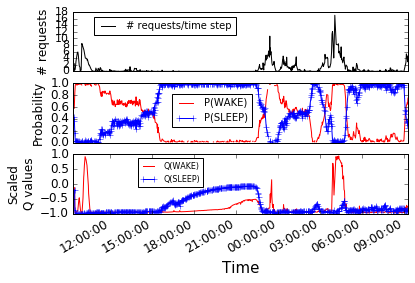

In [25]:
plt.figure(1)
ax = plt.subplot(311)
start = pd.to_datetime("2014-09-25 9:20:00"); end = pd.to_datetime("2014-09-26 9:20:00")
ts = df[['req_generated']][start:end].resample('1Min')
ts = ts.sample(frac=0.5)
ts.columns = pd.Index(['# requests/time step'])
ts.plot(legend=True, ax=ax, 
        style=['k-'], fontsize=11
       )
ax.get_xaxis().set_visible(False)
plt.legend(fontsize=10, bbox_to_anchor=(0.5,1), )
ax.yaxis.set_label_text('# requests')
ax.yaxis.label.set_fontsize(12)
# ------------------------------
ax = plt.subplot(312)
ts = df[['batch_dist_wake', 'batch_dist_sleep']][start:end].resample('1Min')
ts = ts.sample(frac=0.5)
ts.columns = pd.Index(['P(WAKE)', 'P(SLEEP)'])
ts.plot(legend=True, ax=ax, 
        style=['r-','b-+'], fontsize=12
       )
ax.yaxis.set_label_text('Probability')
ax.yaxis.label.set_fontsize(12)
plt.legend(fontsize=8)
ax.get_xaxis().set_visible(False)
plt.legend(bbox_to_anchor=(0.55,0.9), fontsize=10)
# ------------------------------
ax = plt.subplot(313)
ts = df[['q_wake', 'q_sleep']][start:end].resample('1Min')
ts.columns = pd.Index(['Q(WAKE)', 'Q(SLEEP)'])
ts.index.name = 'Time'
ts = ts.sample(frac=0.5)
ts.plot(legend=True, ax=ax, 
        style=['r-','b-+'], fontsize=12 
       )
ax.xaxis.label.set_fontsize(15)
ax.yaxis.set_label_text('Scaled\nQ values')
ax.yaxis.label.set_fontsize(12)
plt.legend(fontsize=8, bbox_to_anchor=(0.4,1),)
# ------------------------------

# Figure 3

In [ ]:
f1 = './log/index_message_2016-6-11_1230_FR1000_G5.log.csv'
df1 = pd.read_csv(f1, delimiter=';', index_col=0)
df1.loc[:, 'start_ts'] = df1['start_ts'].apply(lambda x: pd.to_datetime(x))
df1.set_index('start_ts', inplace=True)
df1['total_reward'] = df1['tr_reward'] - df1['op_cost']
f2 = './log/index_message_2016-6-11_1230_FR20_G5.log.csv'
df2 = pd.read_csv(f2, delimiter=';', index_col=0)
df2.loc[:, 'start_ts'] = df2['start_ts'].apply(lambda x: pd.to_datetime(x))
df2.set_index('start_ts', inplace=True)
df2['total_reward'] = df2['tr_reward'] - df2['op_cost']
f3 = './log/index_message_2016-6-11_1230_FR1_G5.log.csv'
df3 = pd.read_csv(f3, delimiter=';', index_col=0)
df3.loc[:, 'start_ts'] = df3['start_ts'].apply(lambda x: pd.to_datetime(x))
df3.set_index('start_ts', inplace=True)
df3['total_reward'] = df3['tr_reward'] - df3['op_cost']

In [ ]:
plt.figure(1)
# -------------
ax = plt.subplot(311)
start = pd.to_datetime("2014-09-25 9:20:00")
end = pd.to_datetime("2014-09-26 9:20:00")
ts1 = df1[['q_wake', 'q_sleep']][start:end].resample('1Min')
ts1.columns = pd.Index(['Q(WAKE)', 'Q(SLEEP)'])
ts1.plot(
    legend=True, ax=ax, 
        style=['r-','b--'], fontsize=12, title='R=1000',
        ylim=(-1.1,1.1)
       )
ax.get_xaxis().set_visible(False)
plt.legend(bbox_to_anchor=(0.4,1), fontsize=12)
ax.title.set_position((0.5, 0.7))
# -------------
ax = plt.subplot(312)
start = pd.to_datetime("2014-09-25 9:20:00")
end = pd.to_datetime("2014-09-26 9:20:00")
ts2 = df2[['q_wake', 'q_sleep']][start:end].resample('1Min')
ts2.columns = pd.Index(['Q(WAKE)', 'Q(SLEEP)'])
ts2.plot(
#     figsize=(15, 4), 
    legend=False, ax=ax, 
        style=['r-','b--'], fontsize=12, title='R=20',
        ylim=(-1.1,1.1)
       )
ax.get_xaxis().set_visible(False)
ax.title.set_position((0.5, 0.7))
ax.yaxis.set_label_text('Scaled Q values')
ax.yaxis.label.set_fontsize(15)
# -------------
ax = plt.subplot(313)
start = pd.to_datetime("2014-09-25 9:20:00")
end = pd.to_datetime("2014-09-26 9:20:00")
ts3 = df3[['q_wake', 'q_sleep']][start:end].resample('1Min')
ts3.columns = pd.Index(['Q(WAKE)', 'Q(SLEEP)'])
ts3.index.name = 'Time'
ts3.plot(
    legend=False, ax=ax,         
        style=['r-','b--'], fontsize=12,
        ylim=(-1.1,1.1) 
       )
ax.xaxis.label.set_fontsize(15);ax.xaxis.label.set_position((0.5, 0.2)); ax.xaxis.set_label_coords(0.5, -0.4)
ax.annotate('R=1', size=13, xy=(0.51,0.35), xycoords='figure fraction')

# Figure 4

In [22]:
f = './log/index_message_2016-6-12_G5_BUF2_AR1_b5.log.csv'
df = pd.read_csv(f, delimiter=';', index_col=0)
df.loc[:, 'start_ts'] = df['start_ts'].apply(lambda x: pd.to_datetime(x))
df.set_index('start_ts', inplace=True)
df['total_reward'] = 0.5*df['tr_reward'] - 0.5*df['op_cost']
df['a_wake'] = (df.agent_action=='(False, \'serve_all\')')
df['a_sleep'] = (df.agent_action=='(True, None)')
# start = pd.to_datetime("2014-10-16 9:30:00")
end = pd.to_datetime("2014-11-07 0:00:00")
df = df.loc[:end]

start_ts
2014-11-05 09:06:00         NaN
2014-11-05 09:07:00         NaN
2014-11-05 09:08:00         NaN
2014-11-05 09:09:00         NaN
2014-11-05 09:10:00         NaN
2014-11-05 09:11:00         NaN
2014-11-05 09:12:00         NaN
2014-11-05 09:13:00         NaN
2014-11-05 09:14:00         NaN
2014-11-05 09:15:00         NaN
2014-11-05 09:16:00         NaN
2014-11-05 09:17:00         NaN
2014-11-05 09:18:00         NaN
2014-11-05 09:19:00         NaN
2014-11-05 09:20:00    0.080722
2014-11-05 09:21:00    0.775680
2014-11-05 09:22:00    0.998382
2014-11-05 09:23:00    0.842198
2014-11-05 09:24:00    0.996169
2014-11-05 09:25:00    0.891713
2014-11-05 09:26:00    0.804221
2014-11-05 09:27:00    0.754694
2014-11-05 09:28:00    0.806754
2014-11-05 09:29:00    0.905943
2014-11-05 09:30:00    0.952544
2014-11-05 09:31:00    0.962786
2014-11-05 09:32:00    0.955071
2014-11-05 09:33:00    0.932653
2014-11-05 09:34:00    0.944865
2014-11-05 09:35:00    0.930347
                         ...   

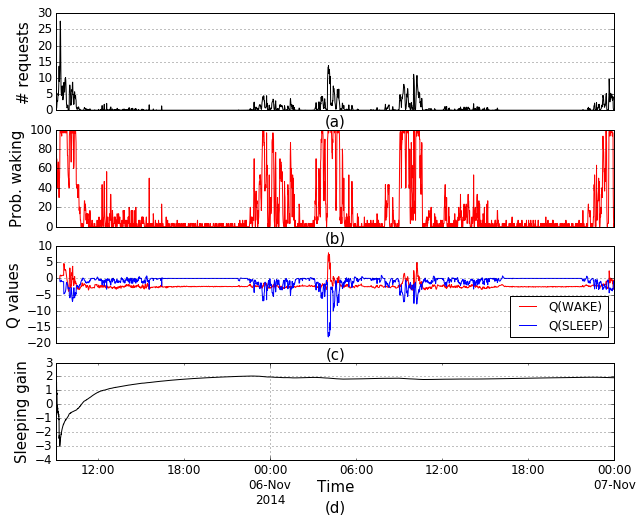

In [23]:
plt.figure(1)
#------------------
ax = plt.subplot(411)
ts = df[['req_generated']].resample('1Min')
ts.columns = pd.Index(['# requests'])
ts.plot(
    figsize=(10, 8), 
    ax=ax, legend=False,
    style=['k-'], fontsize=12, title='(a)',
)
ax.title.set_position((0.5, -0.22)) 
ax.get_xaxis().set_visible(False)
ax.yaxis.set_label_text('# requests')
ax.yaxis.label.set_fontsize(15)
ax.title.set_fontsize(15)
ax.grid()
#------------------
ax = plt.subplot(412)
ts = df[['a_wake']].resample('1Min')*100
ts.columns = pd.Index(['waking percentage'])
ts.plot(
    figsize=(10, 8),
    ax=ax, legend=False,
    style=['r-'], fontsize=12, title='(b)',
)
ax.title.set_position((0.5, -0.22)) 
ax.get_xaxis().set_visible(False)
ax.yaxis.set_label_text('Prob. waking')
ax.yaxis.label.set_fontsize(15)
ax.title.set_fontsize(15)
ax.grid()
#------------------
ax = plt.subplot(413)
ts = df[['q_wake', 'q_sleep']].resample('1Min')
ts.q_wake *= df.reward_scaling.resample('1Min'); ts.q_sleep*=df.reward_scaling.resample('1Min')
ts.columns =pd.Index(['Q(WAKE)', 'Q(SLEEP)'])
ts.plot(
    figsize=(10, 8),
    legend=True, ax=ax, 
    style=['r-','b-'], fontsize=12, title='(c)',
)
ax.title.set_position((0.5, -0.22)) 
ax.get_xaxis().set_visible(False)
ax.yaxis.set_label_text('Q values')
ax.yaxis.label.set_fontsize(15)
ax.title.set_fontsize(15)
ax.grid()
#------------------
ax = plt.subplot(414)
step = (df.index-df.index[0])/delta+1
ts = df['total_reward'].cumsum()/step
ts_on = (0.5*df['req_generated']-0.5*5).cumsum()/step
(ts-ts_on).plot(
    figsize=(10, 8),
    legend=False, ax=ax, 
        style=['k-'], 
#                 ylim=(0, 4), 
                fontsize=12, title='(d)'
       )
ax.title.set_position((0.5, -0.6)) 
ax.yaxis.set_label_text('Sleeping gain')
ax.yaxis.label.set_fontsize(15)
ax.xaxis.label.set_fontsize(15); ax.xaxis.label.set_text('Time'); ax.xaxis.set_label_coords(0.5, -0.2)
ax.title.set_fontsize(15)
ax.grid()

# Figure 5

In [20]:
f = './log/index_message_2016-6-8_2130_AR1.log.csv'
df = pd.read_csv(f, delimiter=';', index_col=0)
df.loc[:, 'start_ts'] = df['start_ts'].apply(lambda x: pd.to_datetime(x))
df.set_index('start_ts', inplace=True)
df['total_reward'] = df['tr_reward'] - df['op_cost']
df['a_wake'] = (df.agent_action=='(False, \'serve_all\')')
df['a_sleep'] = (df.agent_action=='(True, None)')

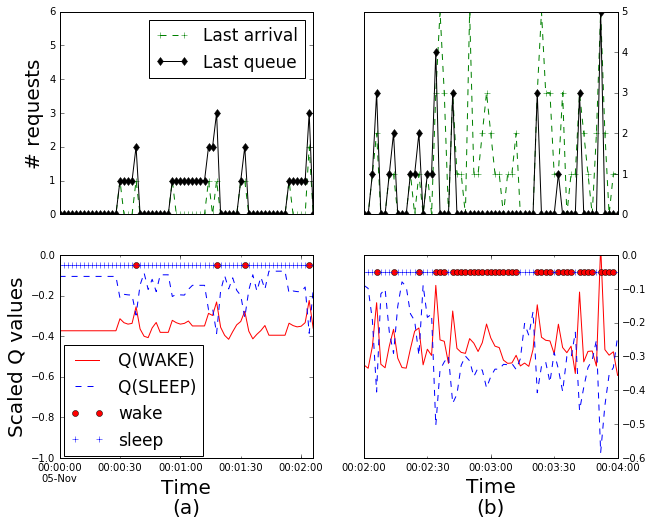

In [21]:
plt.figure(1)
#-------------------
start = pd.to_datetime("2014-11-05 00:00:00")
end = pd.to_datetime("2014-11-05 00:02:06")
ax = plt.subplot(221)
ts = df.ob_last_t[start:end]
ts.name = 'Last arrival'
ts.plot(legend=True, ax=ax, 
        # figsize=(15, 8),
        style=['g--+'])
ax.get_xaxis().set_visible(False)
ax.yaxis.set_label_text('# requests')
ax.yaxis.label.set_fontsize(20)

#-------------------
ax = plt.subplot(221)
ts = df.ob_new_q[start:end]
ts.name = 'Last queue'
ts.plot(legend=True, ax=ax, 
        # figsize=(15, 8),
        style=['k-d'], ylim=(0,6))
ax.get_xaxis().set_visible(False)
ax.yaxis.set_label_text('# requests')
ax.yaxis.label.set_fontsize(20)
plt.legend(bbox_to_anchor=(0.3,1), fontsize=12)
plt.legend(fontsize=17)
#-------------------
ax = plt.subplot(223)
ts = df.loc[start:end][['q_wake', 'q_sleep']]
ts.columns = pd.Index(['Q(WAKE)','Q(SLEEP)'])
ts.plot(legend=True, ax=ax, 
        figsize=(10, 8),style=['r-','b--'])
ax.yaxis.set_label_text('Scaled Q values')
ax.yaxis.label.set_fontsize(20)
#-------------------
ax = plt.subplot(223)
ts = df[['a_wake','a_sleep']].loc[start:end]*3-3.05
ts.columns = pd.Index(['wake', 'sleep'])
ts.plot(legend=True, ax=ax, 
        #figsize=(15, 8),
        style=['ro','b+'], ylim=(-1, 0))
ax.xaxis.label.set_text('Time');ax.xaxis.label.set_fontsize(20); ax.xaxis.set_label_coords(0.5, -0.1)
ax.title.set_text('(a)'); ax.title.set_fontsize(20); ax.title.set_position((0.5, -0.3))
plt.legend(fontsize=17, bbox_to_anchor=(0.6, 0.6))
#-------------------
start = pd.to_datetime("2014-11-07 00:02:00")
end = pd.to_datetime("2014-11-07 00:04:00")
ax = plt.subplot(222)
ts = df.ob_last_t[start:end]
ts.columns = pd.Index(['# request in last step'])
ts.plot(legend=False, ax=ax, 
        #figsize=(15, 8),
        style=['g--+'])
ax.get_xaxis().set_visible(False)
ax.yaxis.set_ticks_position('right')
#-------------------
ax = plt.subplot(222)
ts = df.ob_new_q[start:end]
ts.columns = pd.Index(['# request in last step'])
ts.plot(legend=False, ax=ax, 
        # figsize=(15, 8),
        style=['k-d'])
ax.get_xaxis().set_visible(False)
ax.yaxis.set_ticks_position('right')

#-------------------
ax = plt.subplot(224)
ts = df.loc[start:end][['q_wake', 'q_sleep']]
ts.columns = pd.Index(['Q(WAKE)','Q(SLEEP)'])
ts.plot(legend=False, ax=ax, 
        # figsize=(15, 8),
        style=['r-','b--'])
ax.yaxis.set_ticks_position('right')
#-------------------
ax = plt.subplot(224)
ts = df[['a_wake','a_sleep']].loc[start:end]*3-3.05
ts.columns = pd.Index(['wake', 'sleep'])
ts.plot(legend=False, ax=ax, 
        # figsize=(15, 8),
        style=['ro','b+'], ylim=(-0.6, 0))

ax.xaxis.label.set_text('Time');ax.xaxis.label.set_fontsize(20);
ax.title.set_text('(b)'); ax.title.set_fontsize(20); ax.title.set_position((0.5, -0.3))

plt.savefig("policy.png", bbox_inches='tight', dpi=300)

# Figure 6

 0 mean 3.898, std 0.006, 10% 3.889, 50% 3.900, 90% 3.905, 14 sims
 2 mean 3.908, std 0.003, 10% 3.904, 50% 3.909, 90% 3.913, 14 sims
 5 mean 3.912, std 0.004, 10% 3.906, 50% 3.913, 90% 3.916, 14 sims
10 mean 3.914, std 0.003, 10% 3.910, 50% 3.915, 90% 3.917, 14 sims
12 mean 3.916, std 0.002, 10% 3.913, 50% 3.916, 90% 3.918, 14 sims
16 mean 3.917, std 0.003, 10% 3.916, 50% 3.918, 90% 3.920, 14 sims
20 mean 3.918, std 0.003, 10% 3.915, 50% 3.919, 90% 3.921, 14 sims


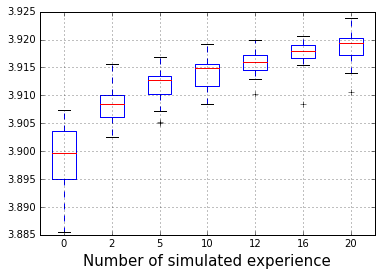

In [38]:
exps = [
    (0, "msg_DynaQNN_130_Feb10_2316", 14),  # dormW, msg_DynaQNN_130_Feb10_2316_x14 (14), n_sim=0, 220min
    (2, "msg_DynaQNN_130_Feb10_2317", 14),  # dormW, msg_DynaQNN_130_Feb10_2317_x14 (14), n_sim=2, 415min
    (5, "msg_DynaQNN_Feb5_1007", 14),  # dormW, msg_DynaQNN_Feb5_1007_x14 (14), num_sim=5, 129min x2
    (10, "msg_DynaQNN_Feb10_2300", 14),  # dormW, msg_DynaQNN_Feb10_2300_x14 (14), n_sim=10, 212min x 2
    (12, "msg_DynaQNN_Feb10_2305", 14),  # dormW, msg_DynaQNN_Feb10_2305_x14 (14), n_sim=12, 255min x 2
    (16, "msg_DynaQNN_Feb10_2302", 14),  # dormW, msg_DynaQNN_Feb10_2302_x14 (14), n_sim=16, 320min x 2
    (20, "msg_DynaQNN_Feb10_2303", 14),  # dormW, msg_DynaQNN_Feb10_2303_x14 (14), n_sim=20, 395min x 2
]
step_rewards, params, means, stds, p10s, p50s, p90s = [], [], [], [], [], [], []
for p, f, n in exps:
    print "{:2d}".format(p),
    step_reward, mean, std, p10, p50, p90 = get_stats(f, n, baseline_dormW)
    step_rewards.append(step_reward), params.append(p), means.append(mean); stds.append(std); p10s.append(p10); p50s.append(p50); p90s.append(p90)
plt.figure(); ax = plt.subplot(111)
pd.DataFrame(np.array(step_rewards).transpose(), columns=params).plot(kind='box', ax=ax)
ax.xaxis.set_label_text('Number of simulated experience')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.grid()

# Figure 7

    2 mean 3.720, std 0.007, 10% 3.712, 50% 3.719, 90% 3.730, 14 sims
    5 mean 3.678, std 0.007, 10% 3.670, 50% 3.678, 90% 3.687, 14 sims
    7 mean 3.667, std 0.007, 10% 3.658, 50% 3.668, 90% 3.676, 14 sims
   10 mean 3.654, std 0.006, 10% 3.648, 50% 3.654, 90% 3.662, 14 sims
   15 mean 3.639, std 0.009, 10% 3.630, 50% 3.637, 90% 3.650, 14 sims
   25 mean 3.618, std 0.011, 10% 3.607, 50% 3.616, 90% 3.635, 14 sims
   50 mean 3.587, std 0.007, 10% 3.581, 50% 3.586, 90% 3.596, 14 sims
  100 mean 3.566, std 0.008, 10% 3.558, 50% 3.563, 90% 3.579, 14 sims
  250 mean 3.533, std 0.015, 10% 3.512, 50% 3.533, 90% 3.553, 14 sims


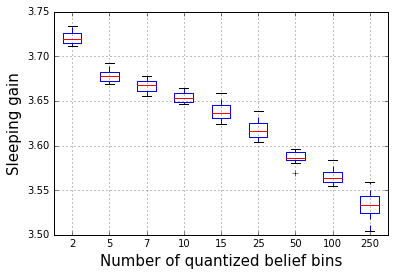

In [39]:
exps = [
    (2, "msg_DynaQtable_Feb7_1324", 14),  # dormW, msg_DynaQtable_Feb7_1324_x14 (14), num_sim=5, n_bins=2, 50min
    (5, "msg_DynaQtable_Feb7_1052", 14),  # dormW, msg_DynaQtable_Feb7_1052_x14 (14), num_sim=5, n_bins=5, 50min
    (7, "msg_DynaQtable_Feb7_1609", 14),  # dormW, msg_DynaQtable_Feb7_1609_x14 (14), num_sim=5, n_bins=7, 50min
    (10, "msg_DynaQtable_Feb6_2008", 14),  # dormW, msg_DynaQtable_Feb6_2008_x14 (14), num_sim=5, n_bins=10, 50min
    (15, "msg_DynaQtable_Feb7_1053", 14),  # dormW, msg_DynaQtable_Feb7_1053_x14 (14), num_sim=5, n_bins=15, 50min
    (25, "msg_DynaQtable_Feb6_2010", 14),  # dormW, msg_DynaQtable_Feb6_2010_x14 (14), num_sim=5, n_bins=25, 50min
    (50, "msg_DynaQtable_Feb6_1543", 14),  # dormW, msg_DynaQtable_Feb6_1543_x14 (14), num_sim=5, n_bins=50, 50min
    (100, "msg_DynaQtable_Feb2_0946", 14),  # dormW, msg_DynaQtable_Feb2_0946_x14 (14), num_sim=5, n_bins=100, 50min
    (250, "msg_DynaQtable_Feb6_1544", 14),  # dormW, msg_DynaQtable_Feb6_1544_x14 (14), num_sim=5, n_bins=250, 50min
]
step_rewards, params, means, stds, p10s, p50s, p90s = [], [], [], [], [], [], []
for p, f, n in exps:
    print "{:5d}".format(int(p)),
    step_reward, mean, std, p10, p50, p90 = get_stats(f, n, baseline_dormW)
    step_rewards.append(step_reward); params.append(p); means.append(mean); stds.append(std); p10s.append(p10); p50s.append(p50); p90s.append(p90)
plt.figure(); ax = plt.subplot(111)
pd.DataFrame(np.array(step_rewards).transpose(), columns=params).plot(kind='box', ax=ax)
ax.xaxis.set_label_text('Number of quantized belief bins')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.set_label_text('Sleeping gain')
ax.yaxis.label.set_fontsize(15)
ax.grid()

# Figure 8

In [9]:
# model fitting overflow control
def adjust(model, epsilon):
    model.startprob_ += epsilon
    model.transmat_ += epsilon
    model.emissionrates_[0] += epsilon
    # model.emissionrates_[1] += epsilon  # when the model is general MMPP
    model.emissionrates_[1] = 0.0  # when the model is IPP
    normalize(model.startprob_)
    normalize(model.transmat_, axis=1)     

In [6]:
f = './log/index/figure8.csv'
df = pd.read_csv(f, delimiter=';')
df.loc[:, 'start_ts'] = df['start_ts'].apply(lambda x: pd.to_datetime(x))
df.set_index('start_ts', inplace=True)
x = df['req_generated']
len(x)

14051

In [7]:
model = MMPP(n_components=2, n_iter=1, init_params='', verbose=False)
model.startprob_ = np.array([.5, .5])
model.transmat_ = np.array([[0.5, 0.5], [0.5, 0.5]])
model.emissionrates_ = np.array([1.0, 0.0])
print 'Start: ',
print model.startprob_
print 'Transitions: '
print model.transmat_
print 'Emission: ',
print model.emissionrates_

Start:  [ 0.5  0.5]
Transitions: 
[[ 0.5  0.5]
 [ 0.5  0.5]]
Emission:  [ 1.  0.]


In [10]:
stride = 2
total_steps = 7000
window_size = 50
epsilon = 1e-22
offset = 0
n_iter = 3

prob0 = np.zeros(total_steps)
trans00 = np.zeros(total_steps)
trans11 = np.zeros(total_steps)
rate0 = np.zeros(total_steps)
rate1 = np.zeros(total_steps)
score = np.zeros(total_steps)
score_exp = np.zeros(total_steps)

for i in range(total_steps):
    x_window = x.iloc[(offset+i*stride):(offset+i*stride+window_size)].as_matrix()[:, None]
    for _ in range(n_iter):
        model.fit(x_window)
        adjust(model, epsilon)
    prob0[i] = model.startprob_[0]
    rate0[i] = model.emissionrates_[0]
    rate1[i] = model.emissionrates_[1]
    trans00[i] = model.transmat_[0, 0]
    trans11[i] = model.transmat_[1, 1]
    # adjust(model, epsilon)
    score[i] = model.score(x_window)/window_size
    score_exp[i] = model.score(model.sample(100)[0])/100
    if i%100 == 0:
        print i,
        print model.startprob_,
        print model.transmat_,
        print model.emissionrates_,
        print score[i],
        print score_exp[i]
print
ticks = range((offset+window_size), (offset+(total_steps-1)*stride+window_size+1), stride)
time_stamps = x.index[ticks]
rate0 = pd.Series(rate0, index=time_stamps); rate1 = pd.Series(rate1, index=time_stamps)
trans00 = pd.Series(trans00, index=time_stamps); trans11 = pd.Series(trans11, index=time_stamps)
score = pd.Series(score, index=time_stamps); score_exp = pd.Series(score_exp, index=time_stamps)

0 [  2.58753167e-07   9.99999741e-01] [[ 0.97167565  0.02832435]
 [ 0.44907839  0.55092161]] [ 3.20467956  0.        ] -2.11882802289 -1.8872500931
100 [  1.00000000e+00   1.00000000e-22] [[  1.00000000e+00   1.00000000e-22]
 [  5.00000000e-01   5.00000000e-01]] [ 10.36734694   0.        ] -2.69048601202 -2.55456804033
200 [  1.00000000e+00   1.00000000e-22] [[  1.00000000e+00   1.00000000e-22]
 [  5.00000000e-01   5.00000000e-01]] [ 13.87755102   0.        ] -2.91675361727 -2.69171057551
300 [  1.00000000e+00   1.00000000e-22] [[  1.00000000e+00   1.00000000e-22]
 [  5.00000000e-01   5.00000000e-01]] [ 10.14285714   0.        ] -2.52166027112 -2.52158766478
400 [  1.00000000e+00   1.00000000e-22] [[  9.99990481e-01   9.51898402e-06]
 [  1.00000000e+00   1.00000000e-22]] [ 4.89800581  0.        ] -2.22786175535 -2.08087974902
500 [  1.00000000e+00   1.44468042e-14] [[  1.00000000e+00   1.00000000e-22]
 [  1.00000000e+00   1.00000000e-22]] [ 6.28571429  0.        ] -2.52916508368 -2.355

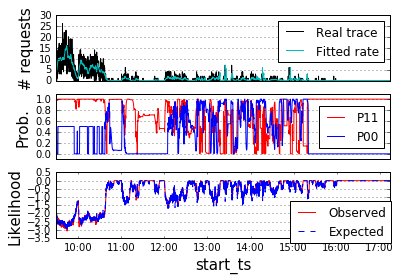

In [11]:
plt.figure()
ax = plt.subplot(311)
df = pd.DataFrame(); df['Real trace'] = x[time_stamps]; df['Fitted rate'] = rate0
df.plot(ax=ax, style=['k-', 'c-'])
ax.get_xaxis().set_visible(False)
ax.yaxis.set_label_text('# requests'); ax.yaxis.label.set_fontsize(15)
ax.grid()
# --------------------
ax = plt.subplot(312)
df = pd.DataFrame(columns=['P11', 'P00']); df.P11 = trans00; df.P00 = trans11;
df.plot(ax=ax, ylim=[-0.1, 1.1],  style=['r', 'b'])
ax.get_xaxis().set_visible(False)
ax.yaxis.set_label_text('Prob.'); ax.yaxis.label.set_fontsize(15)
plt.legend(bbox_to_anchor=(1.0,0.9))
ax.grid()
# --------------------
ax = plt.subplot(313)
df = pd.DataFrame(); df['Observed'] = score; df['Expected'] = score_exp;
ts = score-score_exp; ts.index.name = 'Time'; ts.name = 'Per-step likelihood diff.';
df.plot(ax=ax, style=['r-','b--'],)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.set_label_text('Likelihood'); ax.yaxis.label.set_fontsize(15)
ax.grid()
plt.legend(bbox_to_anchor=(1.02,0.65))

# Figure 9

In [18]:
def extract_df(f):
    df = pd.read_csv(f, delimiter=';', index_col=0)
    df.loc[:, 'start_ts'] = df['start_ts'].apply(lambda x: pd.to_datetime(x))
    df.set_index('start_ts', inplace=True)
    df['total_reward'] = 0.7*df['tr_reward'] - 0.3*df['op_cost']
    df['a_wake'] = (df.agent_action=='(False, \'serve_all\')')
    df['a_sleep'] = (df.agent_action=='(True, None)')
    print f
    return df
def extract_baseline_ts(df, name):
    step = (df.index-df.index[0])/delta+1
    ts = df['total_reward'].cumsum()/step
    ts_on = (0.7*df['req_generated']-0.3*5).cumsum()/step
    ts = (ts-ts_on)
    ts.name = name
    return ts
delta = pd.to_timedelta('2 Seconds')

./log/index_message_2016-6-13_G5_BUF1_FR20_1_2.log.csv
./log/index_message_2016-6-13_G5_BUF2_FR20_1.log.csv
./log/index_message_2016-6-13_G5_BUF1_FR20_1_1.log.csv


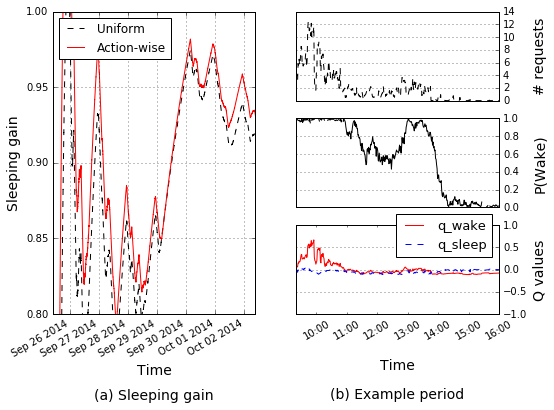

In [19]:
plt.figure(1)
#--------------------
ax = plt.subplot(121)
f = './log/index_message_2016-6-13_G5_BUF1_FR20_1_2.log.csv'
df = extract_df(f)
ts = extract_baseline_ts(df, 'Uniform')
ts.plot(figsize=(9, 6), legend=True, ax=ax, 
        style=['k--'],  )
f = './log/index_message_2016-6-13_G5_BUF2_FR20_1.log.csv'
df = extract_df(f)
ts = extract_baseline_ts(df, 'Action-wise')
ts.plot(figsize=(9, 6), legend=True, ax=ax, 
        style=['r-'], ylim=(0.8,1))
ax.title.set_text('(a) Sleeping gain'); ax.title.set_fontsize(14);  ax.title.set_position((0.5, -0.3))
ax.xaxis.label.set_fontsize(14); ax.xaxis.label.set_text('Time')
ax.yaxis.label.set_text('Sleeping gain'); ax.yaxis.label.set_fontsize(14)
ax.grid()
#---------------------
start = pd.to_datetime("2014-9-27 09:20:00")
end = pd.to_datetime("2014-9-27 16:00:00")
ax = plt.subplot(322)
f = './log/index_message_2016-6-13_G5_BUF1_FR20_1_1.log.csv'
df = extract_df(f)
ts = df.req_generated[start:end].resample('1Min')
ts.plot(figsize=(9, 6), legend=False, ax=ax, 
        style=['k--']
       )
ax.get_xaxis().set_visible(False)
ax.yaxis.label.set_text('# requests'); ax.yaxis.label.set_fontsize(14); ax.yaxis.set_label_coords(1.17, 0.5)
ax.yaxis.set_label_position('right'); ax.yaxis.set_ticks_position('right')
ax.grid()
# #------------------------------
ax = plt.subplot(324)
ts = df.batch_dist_wake[start:end].resample('1Min')
ts.plot(figsize=(9, 6), legend=False, ax=ax, 
        style=['k-'], ylim=(0,1)
       )
ax.get_xaxis().set_visible(False)
ax.yaxis.label.set_text('P(Wake)'); ax.yaxis.label.set_fontsize(14); ax.yaxis.set_label_coords(1.17, 0.5)
ax.yaxis.set_label_position('right');ax.yaxis.set_ticks_position('right')
ax.grid()
#------------------------------
ax = plt.subplot(326)
ts = df[['q_wake', 'q_sleep']][start:end].resample('1Min')
ts.plot(figsize=(8, 6), legend=True, ax=ax, 
        style=['r-', 'b--'], ylim=(-1,1), rot=30
       )
plt.legend(bbox_to_anchor=(1,1.2), fontsize=13)
ax.xaxis.label.set_fontsize(14); ax.xaxis.label.set_text('Time'); ax.xaxis.set_label_coords(0.5, -0.5)
ax.yaxis.label.set_text('Q values'); ax.yaxis.label.set_fontsize(14);ax.yaxis.set_label_position('right'); ax.yaxis.set_ticks_position('right')
ax.title.set_text('(b) Example period'); ax.title.set_fontsize(14); ax.title.set_position((0.5, -1))
ax.grid()

# Figure 10

In [15]:
def extract_df(f):
    df = pd.read_csv(f, delimiter=';', index_col=0)
    df.loc[:, 'start_ts'] = df['start_ts'].apply(lambda x: pd.to_datetime(x))
    df.set_index('start_ts', inplace=True)
    df['total_reward'] = 0.5*df['tr_reward'] - 0.5*df['op_cost']
    print f
    return df
def extract_baseline_ts(df, name):
    step = (df.index-df.index[0])/delta+1
    ts = df['total_reward'].cumsum()/step
    ts_on = (0.5*df['req_generated']-0.5*5).cumsum()/step
    ts = (ts-ts_on)
    ts.name = name
    return ts

delta = pd.to_timedelta('2 Seconds')

./log/index_message_2016-6-12_G5_BUF2_AR1.log.csv
./log/index_message_2016-6-12_G5_BUF2_AR1.log.csv
./log/index_message_2016-6-11_BUF2_G5_FR1.log.csv
./log/index_message_2016-6-11_BUF2_G5.log.csv
./log/index_message_2016-6-11_BUF2_G5_FR100.log.csv
./log/index_message_2016-6-12_G9_BUF2_AR1.log.csv
./log/index_message_2016-6-12_G9_BUF2_FR1.log.csv
./log/index_message_2016-6-12_G9_BUF2_FR20.log.csv
./log/index_message_2016-6-12_G9_BUF2_FR100.log.csv


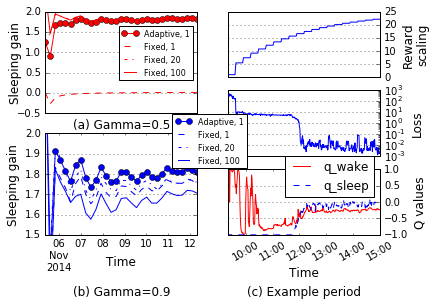

In [16]:
plt.figure(1)
#----------
#--------------------
start = pd.to_datetime("2014-11-05 09:20:36")
end = pd.to_datetime("2014-11-05 15:00:00")
ax = plt.subplot(322)
df = extract_df('./log/index_message_2016-6-12_G5_BUF2_AR1.log.csv')
df[start:end].reward_scaling.resample('1Min').plot(ax=ax)
ax.get_xaxis().set_visible(False)
ax.grid()
ax.yaxis.label.set_text('Reward\nscaling');ax.yaxis.label.set_fontsize(12); ax.yaxis.set_label_position('right');ax.yaxis.set_ticks_position('right')
ax = plt.subplot(324)
df[start:end].loss.resample('1Min').plot(ax=ax, logy=True)
ax.get_xaxis().set_visible(False)
ax.grid()
ax.yaxis.label.set_text('Loss');ax.yaxis.label.set_fontsize(12);ax.yaxis.set_label_position('right');ax.yaxis.set_ticks_position('right')
ax = plt.subplot(326)
df[start:end][['q_wake','q_sleep']].resample('1Min').plot(ax=ax, 
#                                                           ylim=(-1.1, 1.1), 
                                                          style=['r-', 'b--'], rot=30)
ax.xaxis.label.set_fontsize(12);ax.xaxis.label.set_text('Time')
ax.grid()
ax.yaxis.label.set_text('Q values');ax.yaxis.label.set_fontsize(12); ax.yaxis.set_label_position('right');ax.yaxis.set_ticks_position('right')
plt.legend(bbox_to_anchor=(1,1.3), fontsize=12)
ax.title.set_text('(c) Example period'); ax.title.set_fontsize(12); ax.title.set_position((0.5, -1))
#--------------------
ax = plt.subplot(221)
df = extract_df('./log/index_message_2016-6-12_G5_BUF2_AR1.log.csv')
ts = extract_baseline_ts(df, 'Adaptive, 1')
ts.iloc[1:-1:10000].plot(legend=True, ax=ax, style=['r-o'])
df = extract_df('./log/index_message_2016-6-11_BUF2_G5_FR1.log.csv')
ts = extract_baseline_ts(df, 'Fixed, 1')
ts.iloc[1:-1:10000].plot(legend=True, ax=ax,style=['r--'])
df = extract_df('./log/index_message_2016-6-11_BUF2_G5.log.csv')
ts = extract_baseline_ts(df, 'Fixed, 20')
ts.iloc[1:-1:10000].plot(legend=True, ax=ax,style=['r-.'])
df = extract_df('./log/index_message_2016-6-11_BUF2_G5_FR100.log.csv')
ts = extract_baseline_ts(df, 'Fixed, 100')
ts.iloc[1:-1:10000].plot(legend=True, ax=ax, style=['r-'], 
                         ylim=(-0.5, 2)
                        )
ax.grid()
ax.get_xaxis().set_visible(False)
ax.title.set_text('(a) Gamma=0.5'); ax.title.set_fontsize(12); ax.title.set_position((0.5,-0.2))
plt.legend(bbox_to_anchor=(1,0.9), fontsize=8)
ax.yaxis.label.set_text('Sleeping gain'); ax.yaxis.label.set_fontsize(12); ax.yaxis.set_label_coords(-0.15,0.5)
#--------------------
ax = plt.subplot(223)
df = extract_df('./log/index_message_2016-6-12_G9_BUF2_AR1.log.csv')
ts = extract_baseline_ts(df, 'Adaptive, 1')
ts.iloc[1:-1:10000].plot(legend=True, ax=ax, style=['b-o'])
df = extract_df('./log/index_message_2016-6-12_G9_BUF2_FR1.log.csv')
ts = extract_baseline_ts(df, 'Fixed, 1')
ts.iloc[1:-1:10000].plot(legend=True, ax=ax,style=['b--'])
df = extract_df('./log/index_message_2016-6-12_G9_BUF2_FR20.log.csv')
ts = extract_baseline_ts(df, 'Fixed, 20')
ts.iloc[1:-1:10000].plot(legend=True, ax=ax,style=['b-.'])
df = extract_df('./log/index_message_2016-6-12_G9_BUF2_FR100.log.csv')
ts = extract_baseline_ts(df, 'Fixed, 100')
ts.iloc[1:-1:10000].plot(legend=True, ax=ax, style=['b-'], ylim=(1.5, 2))
ax.grid()
ax.xaxis.label.set_text('Time'); ax.xaxis.label.set_fontsize(12); ax.xaxis.set_label_coords(0.5, -0.2)
ax.title.set_text('(b) Gamma=0.9'); ax.title.set_fontsize(12); ax.title.set_position((0.5,-0.65))
plt.legend(bbox_to_anchor=(1.35,1.23), fontsize=8)
ax.yaxis.label.set_text('Sleeping gain'); ax.yaxis.label.set_fontsize(12)
#----------------------

plt.savefig("adaptive.png", bbox_inches='tight', dpi=300)

# Figure 11

In [12]:
f_list = [
    "message_2016-6-12_G5_BUF2_AR1_b1.log",
    "message_2016-6-12_G5_BUF2_AR1_b15.log",
    "message_2016-6-12_G5_BUF2_AR1_b2.log",
    "message_2016-6-12_G5_BUF2_AR1_b25.log",
    "message_2016-6-12_G5_BUF2_AR1_b3.log",
    "message_2016-6-12_G5_BUF2_AR1_b35.log",
    "message_2016-6-12_G5_BUF2_AR1_b4.log",
    "message_2016-6-12_G5_BUF2_AR1_b5.log",
    "message_2016-6-12_G5_BUF2_AR1_b55.log",
    "message_2016-6-12_G5_BUF2_AR1_b6.log",
    "message_2016-6-12_G5_BUF2_AR1_b65.log",
    "message_2016-6-12_G5_BUF2_AR1_b7.log",
    "message_2016-6-12_G5_BUF2_AR1_b8.log",
]

In [13]:
def get_reward(df):
    tr_wait = -1.0*sum(df.tr_reward_wait)/sum(df.req_generated)
    op_cost = mean(df.op_cost)
    return tr_wait, op_cost
def get_df(f):
    f = './log/index_'+f+'.csv'
    df = pd.read_csv(f, delimiter=';', index_col=0)
    df.loc[:, 'start_ts'] = df['start_ts'].apply(lambda x: pd.to_datetime(x))
    df.set_index('start_ts', inplace=True)
    return df
tups = [None]*len(f_list)
for i, f in enumerate(f_list):
    print f
    tups[i] = get_reward(get_df(f))

message_2016-6-12_G5_BUF2_AR1_b1.log
message_2016-6-12_G5_BUF2_AR1_b15.log
message_2016-6-12_G5_BUF2_AR1_b2.log
message_2016-6-12_G5_BUF2_AR1_b25.log
message_2016-6-12_G5_BUF2_AR1_b3.log
message_2016-6-12_G5_BUF2_AR1_b35.log
message_2016-6-12_G5_BUF2_AR1_b4.log
message_2016-6-12_G5_BUF2_AR1_b5.log
message_2016-6-12_G5_BUF2_AR1_b55.log
message_2016-6-12_G5_BUF2_AR1_b6.log
message_2016-6-12_G5_BUF2_AR1_b65.log
message_2016-6-12_G5_BUF2_AR1_b7.log
message_2016-6-12_G5_BUF2_AR1_b8.log


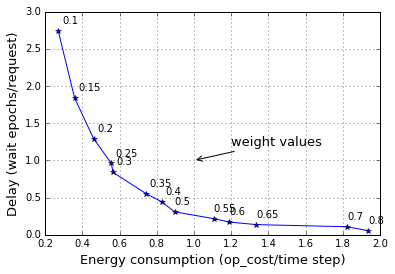

In [14]:
plt.figure(1)
#--------------------
ax = plt.subplot(111)
beta = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 
        0.5, 0.55, 0.6, 0.65, 0.7, 0.8,]
y=[tup[0] for i, tup in enumerate(tups)]
x=[tup[1] for i, tup in enumerate(tups)]
plt.plot(x[:],y[:], 'b-*')
for i in range(len(x)/2+1):
    ax.annotate(str(beta[i]), xy=(x[i]+0.02, y[i]+0.1))
for i in range(len(x)/2+1, len(x)):
    ax.annotate(str(beta[i]), xy=(x[i]+0, y[i]+0.1))
ax.annotate('weight values', xy=(1, 1), xytext=(1.2,1.2), size=13, arrowprops=dict(arrowstyle="->"))
ax.yaxis.label.set_fontsize(13)
ax.yaxis.label.set_text('Delay (wait epochs/request)')
ax.xaxis.label.set_fontsize(13)
ax.xaxis.label.set_text('Energy consumption (op_cost/time step)')
ax.grid()